# **Problem Statement (Final model)**

The objective of this project is to design and implement a vision-based *Advanced Driver Assistance System (ADAS)* using a front-facing driving video. The system must operate on continuous video input and perform the following tasks in real time:

**1. Lane Detection and Lane Area Estimation**

The system shall detect left and right road lane boundaries using classical image processing techniques. Based on the detected lanes, the drivable lane area and lane center must be estimated and visualized on the video frames.

**2. Vehicle Detection using YOLO**

The system shall detect road vehicles such as cars and trucks using a pretrained YOLO object detection model. For each detected vehicle, a bounding box and confidence score must be displayed on the frame.

**3. Masked Region of Interest (ROI) Processing**

A fixed road-facing Region of Interest (ROI) must be defined ahead of the vehicle. Binary masking shall be applied to isolate this region, and only vehicles entering this masked region shall be considered for further safety and traffic analysis.

**4. Vehicle Counting within ROI**

The system shall count the total number of unique vehicles that enter the masked ROI during the video. Each vehicle must be counted only once, based on its spatial entry into the region.

**5. Forward Collision Risk Estimation**

The system shall estimate collision risk using the relative position and size of detected vehicle bounding boxes within the ROI. Vehicles closer to the bottom of the frame or exceeding a predefined size threshold shall trigger appropriate safety warnings.

**6. Lane Departure Warning**

The system shall monitor the vehicle’s position relative to the estimated lane center. If the deviation exceeds a defined threshold, a lane departure warning must be generated.

**7. Unified ADAS Visualization**

All outputs including lane overlays, detected vehicles, ROI mask, vehicle count, and warning messages must be displayed together on a single annotated video stream.

In [94]:
!pip install ultralytics

In [95]:
# 1. Lane Detection And Lane Area Estimation

In [96]:
import cv2
import numpy as np

class LaneProcessor:
    def __init__(self, roi_vertices):
        self.left_lane = None
        self.right_lane = None
        self.lane_center = None
        self.roi_vertices = roi_vertices

    def process_frame(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)

        mask = np.zeros_like(edges)
        cv2.fillPoly(mask, [self.roi_vertices], 255)
        masked_edges = cv2.bitwise_and(edges, mask)

        return frame, masked_edges

    def detect_lanes(self, frame, masked_edges):
        lines = cv2.HoughLinesP(
            masked_edges, 1, np.pi / 180,
            threshold=80, minLineLength=60, maxLineGap=150
        )

        if lines is None:
            return None

        left, right = [], []

        for line in lines:
            x1, y1, x2, y2 = line[0]
            if x2 == x1:
                continue

            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1

            if slope < -0.5:
                left.append((slope, intercept))
            elif slope > 0.5:
                right.append((slope, intercept))

        if not left or not right:
            return None

        return np.vstack((np.mean(left, axis=0), np.mean(right, axis=0)))

    def draw_lanes(self, frame, lanes):
        left_slope, left_intercept = lanes[0]
        right_slope, right_intercept = lanes[1]

        h, w = frame.shape[0], frame.shape[1]
        y1, y2 = h, int(0.6 * h)

        lx1 = int((y1 - left_intercept) / left_slope)
        lx2 = int((y2 - left_intercept) / left_slope)
        rx1 = int((y1 - right_intercept) / right_slope)
        rx2 = int((y2 - right_intercept) / right_slope)

        lx1 = int(np.clip(lx1, 0, w - 1))
        lx2 = int(np.clip(lx2, 0, w - 1))
        rx1 = int(np.clip(rx1, 0, w - 1))
        rx2 = int(np.clip(rx2, 0, w - 1))


        overlay = frame.copy()
        pts = np.array([[lx1, y1], [lx2, y2], [rx2, y2], [rx1, y1]], np.int32)
        cv2.fillPoly(overlay, [pts], (0, 255, 0))
        cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

        cv2.line(frame, (lx1, y1), (lx2, y2), (0, 255, 255), 4)
        cv2.line(frame, (rx1, y1), (rx2, y2), (0, 255, 255), 4)

        lane_center = (lx1 + rx1) // 2
        return frame, lane_center

In [97]:
# 2. Vehicle Detection Using YOLO

In [98]:
class vehicle_detect:
    def __init__(self, model):
        self.model = model

    def detect_vehicles(self, frame, detections):
        for cx, cy, w, h, _ in detections:
            x1 = int(cx - w / 2)
            y1 = int(cy - h / 2)
            x2 = int(cx + w / 2)
            y2 = int(cy + h / 2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 255), 2)
        return frame

In [99]:
# 3. Masked Region Of Interest (ROI) Processing and # 4. Vehicle Counting within ROI

In [100]:
import numpy as np
import cv2

class TrafficAnalyser:
    def __init__(self, roi_vertices, frame_height):
        self.roi_vertices = roi_vertices
        self.counted_ids = set()
        self.total_count = 0
        self.entry_line_y = int(0.75 * frame_height)

    def process_traffic(self, frame, detections):
       for cx, cy, w, h, id in detections:
        center = (int(cx), int(cy))
        inside_roi = cv2.pointPolygonTest(
            self.roi_vertices, center, False)>= 0

        if inside_roi and id not in self.counted_ids:
            self.counted_ids.add(id)

       self.total_count = len(self.counted_ids)

       cv2.putText(
        frame,
        f'Total Count: {self.total_count}',(10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,0.8,(0, 255, 0),2)

       return frame



In [101]:
# 5. Forward Collision Risk Estimation

In [102]:
import numpy as np
import cv2

class CollisionRiskEstimator:
    def __init__(self, frame_height, distance_threshold, size_threshold):
        self.frame_height = frame_height

        # class-based normalization (YOLOv8)
        self.class_weight = {
            2: 1.2,   # car (boost)
            3: 1.1,   # motorcycle
            5: 0.8,   # bus
            7: 0.8    # truck
        }

    def estimate_collision_risk(self, frame, detections):
        collision_warning = False
        best_risk = 0
        threat = None
        frame_area = frame.shape[0] * frame.shape[1]

        for cx, cy, w, h, cls_id in detections:
            x1 = int(cx - w / 2)
            y1 = int(cy - h / 2)
            x2 = int(cx + w / 2)
            y2 = int(cy + h / 2)

            dist_bottom = self.frame_height - y2
            area_ratio = (w * h) / frame_area

            # distance-dominant + class normalized risk
            weight = self.class_weight.get(cls_id, 1.0)
            risk = weight * (0.7 / (dist_bottom + 1) + 0.3 * area_ratio)

            if dist_bottom < 0.4 * self.frame_height and risk > 0.015:
                if risk > best_risk:
                   best_risk = risk
                   threat = (x1, y1, x2, y2)


        if threat:
            collision_warning = True
            x1, y1, x2, y2 = threat
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 4)
            cv2.putText(frame,
                "WARNING: COLLISION RISK",
                (10, 90),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0, 0, 255),3)

        return frame, collision_warning

In [103]:
# 6. Lane Departure Warning

In [104]:
class LaneDepartureWarning:
    def __init__(self, deviation_threshold):
        self.deviation_threshold = deviation_threshold

    def check_lane_departure(self, frame, lane_center, detections):
        if lane_center is None:
            return frame, False

        vehicle_center = frame.shape[1] // 2
        deviation = lane_center - vehicle_center

        if abs(deviation) > self.deviation_threshold:
            cv2.putText(frame, "WARNING: LANE DEPARTURE",
                        (10, 60), cv2.FONT_HERSHEY_SIMPLEX,
                        1.0, (0, 0, 255), 3)
            return frame, True

        return frame, False

In [105]:
# 7. Unified ADAS visualisation

Displaying frame 20


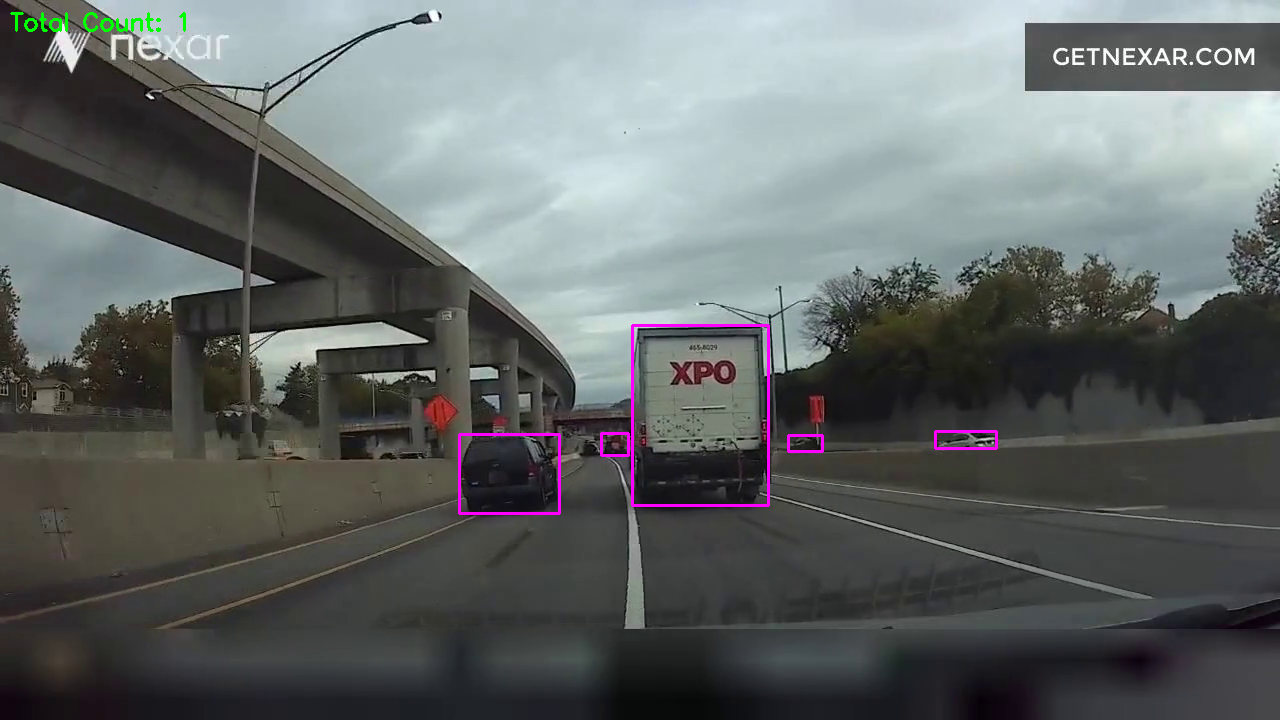

Displaying frame 35


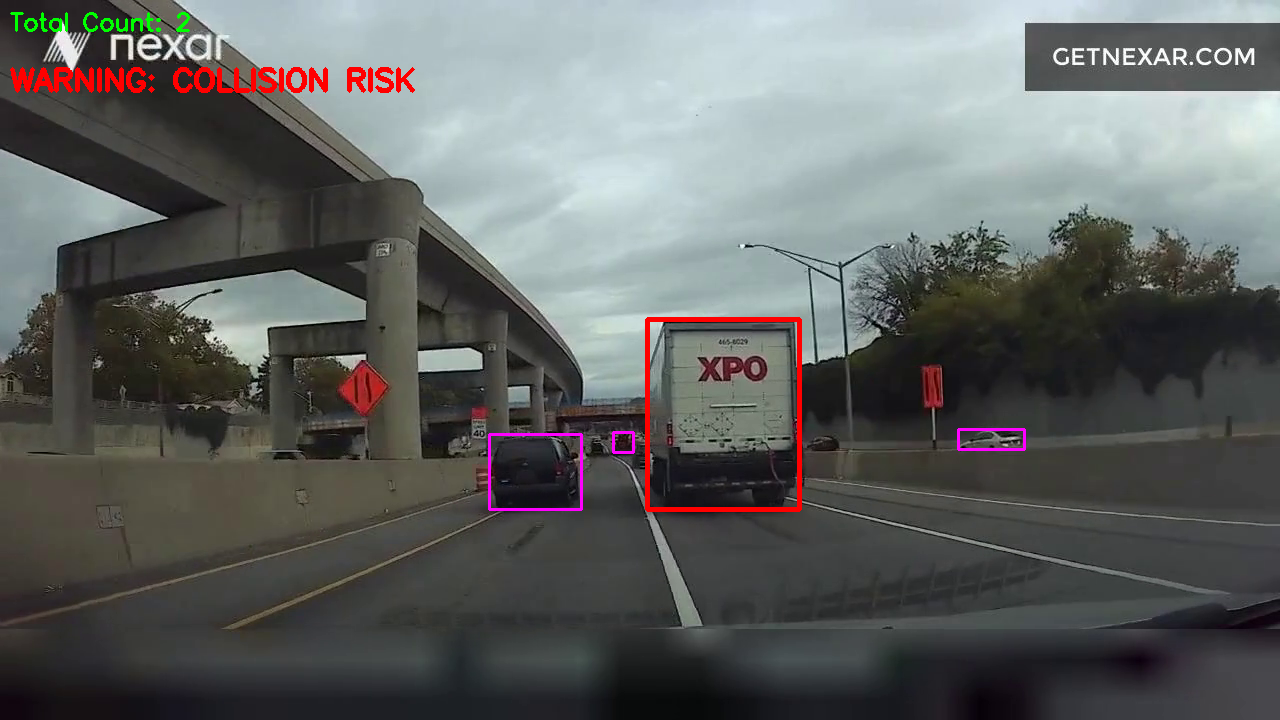

Displaying frame 54


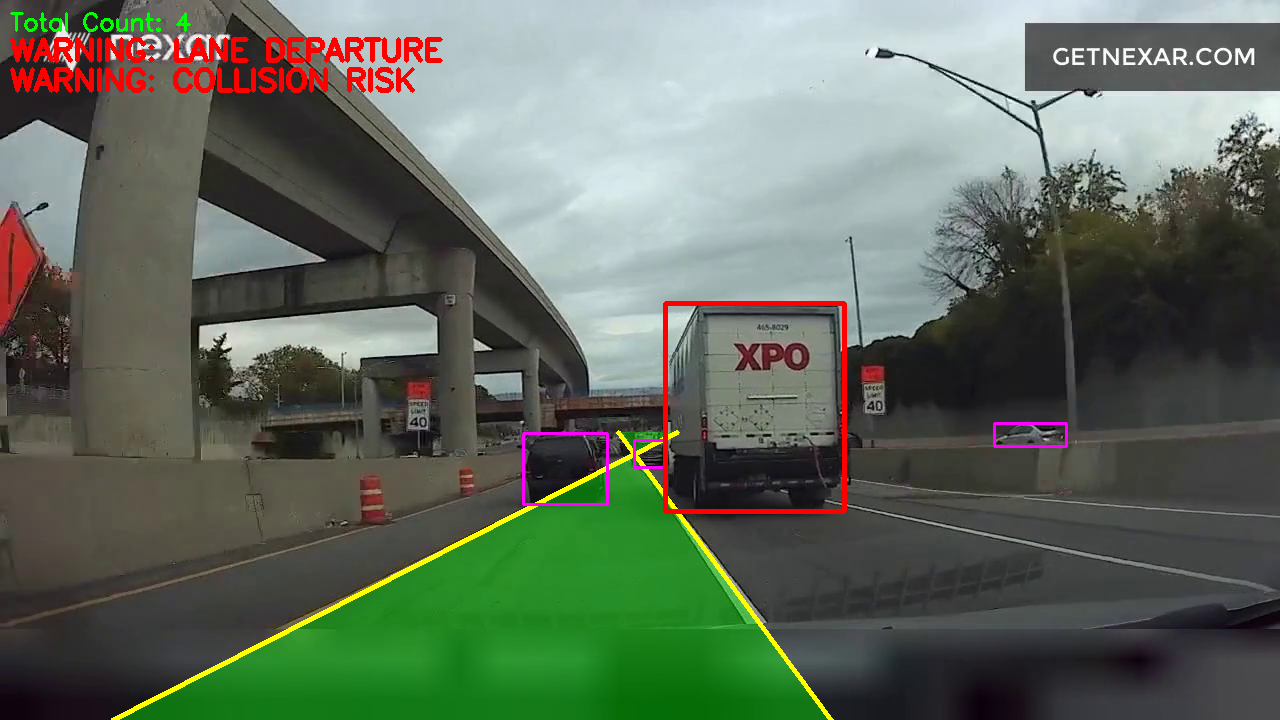

Displaying frame 80


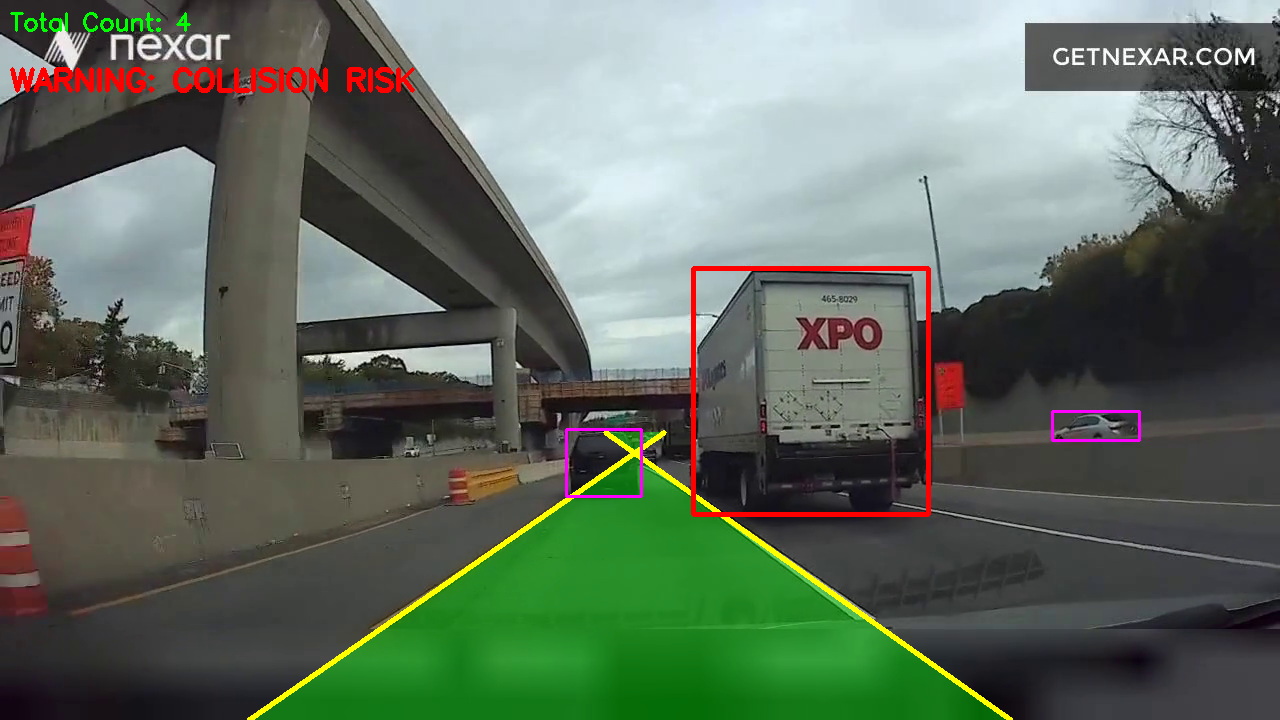

In [106]:
from ultralytics import YOLO
import math
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

DISPLAY_THESE_FRAMES = [20, 35, 54, 80]

cap = cv2.VideoCapture('01095.mp4')
model = YOLO('yolov8m.pt').to('cuda')

success, first_frame = cap.read()
if not success:
    exit()

h, w = first_frame.shape[0], first_frame.shape[1]
roi_vertices = np.array([[(int(0.1*w), h),
     (int(0.45*w), int(0.6*h)),
     (int(0.55*w), int(0.6*h)),
     (int(0.9*w), h)]],
     dtype=np.int32).reshape(-1,1,2)

out = cv2.VideoWriter(
    "ADAS_Output.avi",
    cv2.VideoWriter_fourcc(*"XVID"),
    cap.get(cv2.CAP_PROP_FPS), (w,h))

lane_detector = LaneProcessor(roi_vertices)
vehicle_detector = vehicle_detect(model)
traffic_analyser = TrafficAnalyser(roi_vertices, h)
collision_estimator = CollisionRiskEstimator(first_frame.shape[0], 0.8, 0.25)
lane_departure_warning = LaneDepartureWarning(int(0.05 * w))
frame_count = 0
lane_center = None
VEHICLE_CLASSES = {2, 3, 5, 7}  #car, motorcycle, bus, truck

while True:
    success, frame = cap.read()
    if not success:
        break
    frame_count += 1
    detections = []

    results = model.track(frame, persist=True, tracker="bytetrack.yaml", verbose=False)
    if results[0].boxes.id is not None:
       boxes = results[0].boxes.xywh.cpu().numpy()
       ids = results[0].boxes.id.cpu().numpy()

    cls = results[0].boxes.cls.cpu().numpy().astype(int)

    valid = [i for i,c in enumerate(cls) if c in VEHICLE_CLASSES]
    boxes = boxes[valid]
    ids = ids[valid]

    for (cx, cy, w, h), tid in zip(boxes, ids):
        detections.append((cx, cy, w, h, tid))

    frame, masked_edges = lane_detector.process_frame(frame)
    lanes = lane_detector.detect_lanes(frame, masked_edges)

    if lanes is not None:
        frame, lane_center = lane_detector.draw_lanes(frame, lanes)

    frame = vehicle_detector.detect_vehicles(frame, detections)
    frame = traffic_analyser.process_traffic(frame, detections)
    frame, collision_warning = collision_estimator.estimate_collision_risk(frame, detections)

    if lane_center is not None:
        frame, lane_departure_flag = lane_departure_warning.check_lane_departure(frame, lane_center, detections)

    out.write(frame)

    if frame_count in DISPLAY_THESE_FRAMES:
       print(f"Displaying frame {frame_count}")
       cv2_imshow(frame)


cap.release()
out.release()
cv2.destroyAllWindows()

In [107]:
!ffmpeg -y -i ADAS_Output.avi -vcodec libx264 ADAS_Output.mp4
from google.colab import files
files.download("ADAS_Output.mp4")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>